In [1]:
import re
import numpy as np
import math
import tensorflow as tf
import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import OneHotEncoder


# Data loading

In [2]:
filenames = np.loadtxt('3000files.csv', dtype=str, delimiter=',')
filenames = np.array([filename[1:-1] for filename in filenames])

In [3]:
# filenames = os.listdir('data/celeba/img_align_celeba/')
# np.random.shuffle(filenames)
# filenames = ['/'.join(('data/celeba/img_align_celeba/', filename)) for filename in filenames[:3000]]
# img=mpimg.imread(filenames[10])

In [4]:
# This cell includes the splittign of training and test set.
X = np.stack(map(mpimg.imread, filenames))

shapeX = X.shape

X = X.reshape((shapeX[0],-1))
X = 2*(X / 255) - 1 #Normalize to -1,1
# meanX = np.mean(X, 0)
# stdX = np.std(X, 0) 
# X = (X - meanX)/stdX # Mean removal and variance scaling

X_train, X_test = model_selection.train_test_split(X, test_size=0.33, random_state=42)

In [5]:
def imshow(x, ax=None):
    rescaled = (255*(x + 1)//2).astype('uint8')
    if ax is None:
        plt.imshow(rescaled.reshape(shapeX[1],shapeX[2], shapeX[3]))
    else:
        ax.imshow(rescaled.reshape(shapeX[1],shapeX[2], shapeX[3]))

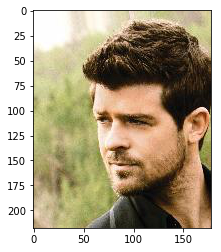

In [6]:
imshow(X[0])

# Optimal Encoding

In [7]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [8]:
n_in = X.shape[-1]
n_cts = 100
n_categorical = 1

depth = 5
widths = [700, 700, 700, 700, 700]

In [9]:
encoder = MLP(n_in, 2*n_cts + n_categorical, depth, widths)
decoder = MLP(n_cts + n_categorical, n_in, depth, widths)

In [10]:
oe = OptimalEncoding(encoder, decoder, n_cts, n_categorical)

100%|██████████| 8000/8000 [5:56:19<00:00,  2.67s/it]  


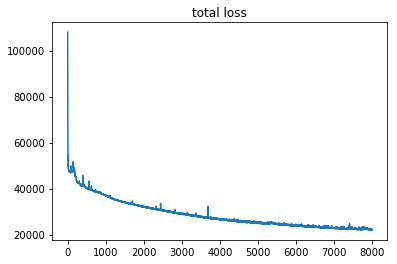

In [11]:
oe.train(X_train, epochs=8000, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [12]:
zhat = oe.encode(X_train)

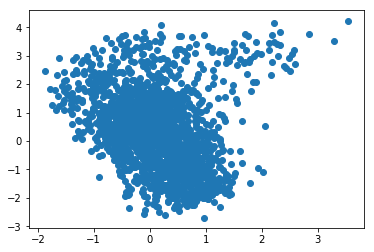

In [13]:
plt.scatter(zhat[:,0], zhat[:,10])

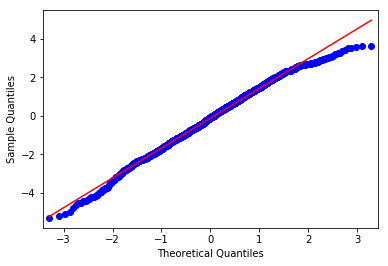

In [14]:
from statsmodels.graphics.gofplots import qqplot
qq = qqplot(zhat[:,20], line='s')

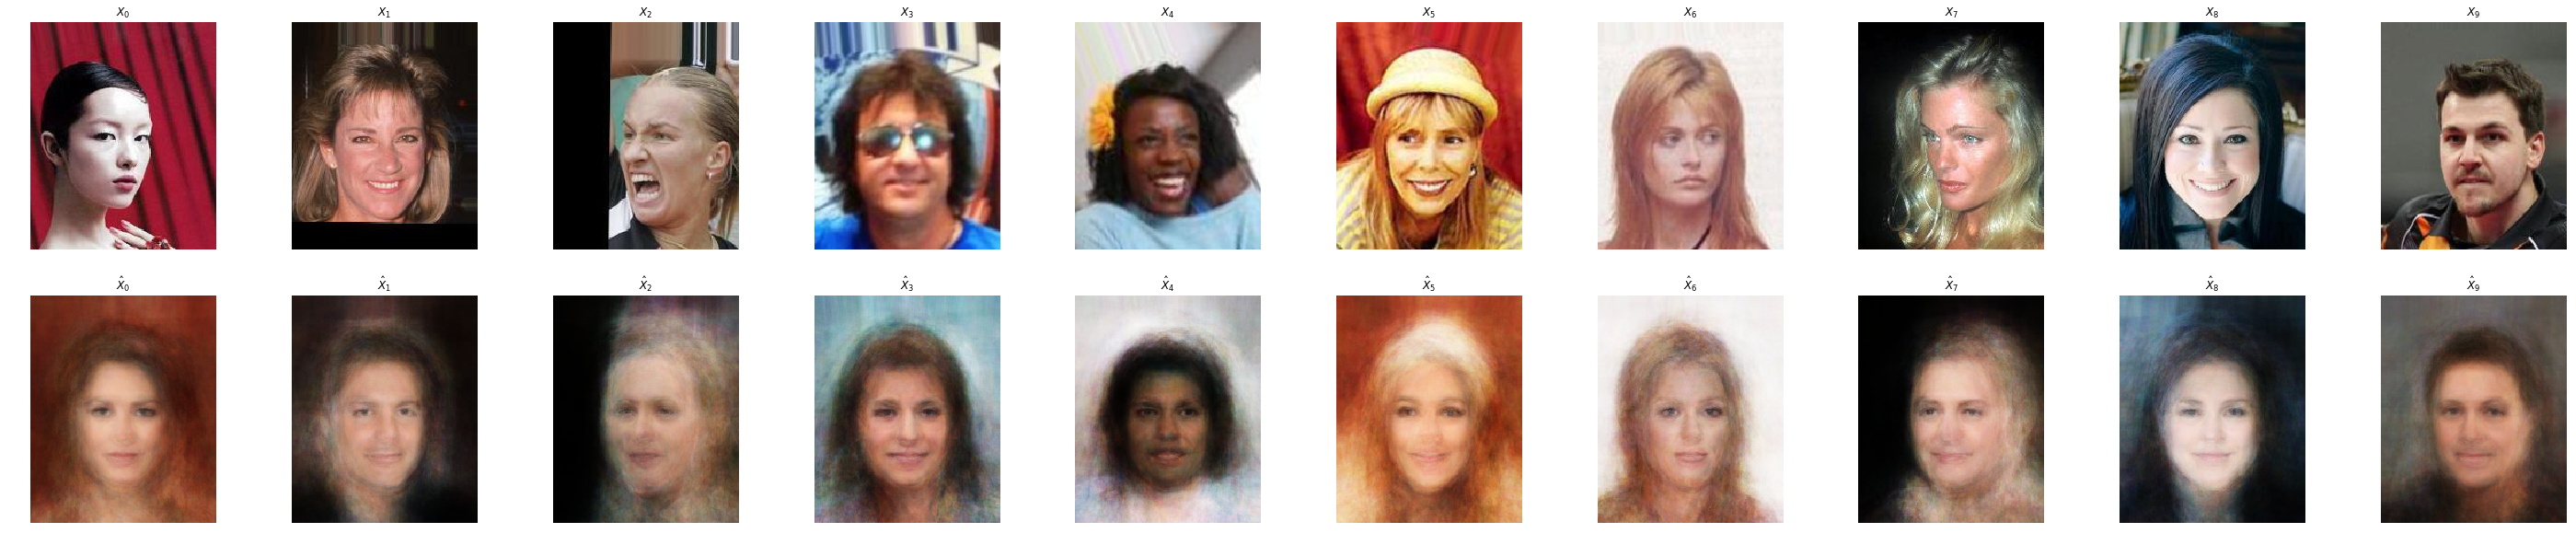

In [15]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (50,10), nrows=2, ncols=10)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            imshow(X_train[j], subplt)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            imshow(xhat[j], subplt)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [16]:
np.mean(zhat[:,-n_categorical:], 0)

array([ 1.], dtype=float32)

In [17]:
zhat = oe.encode(X_test)

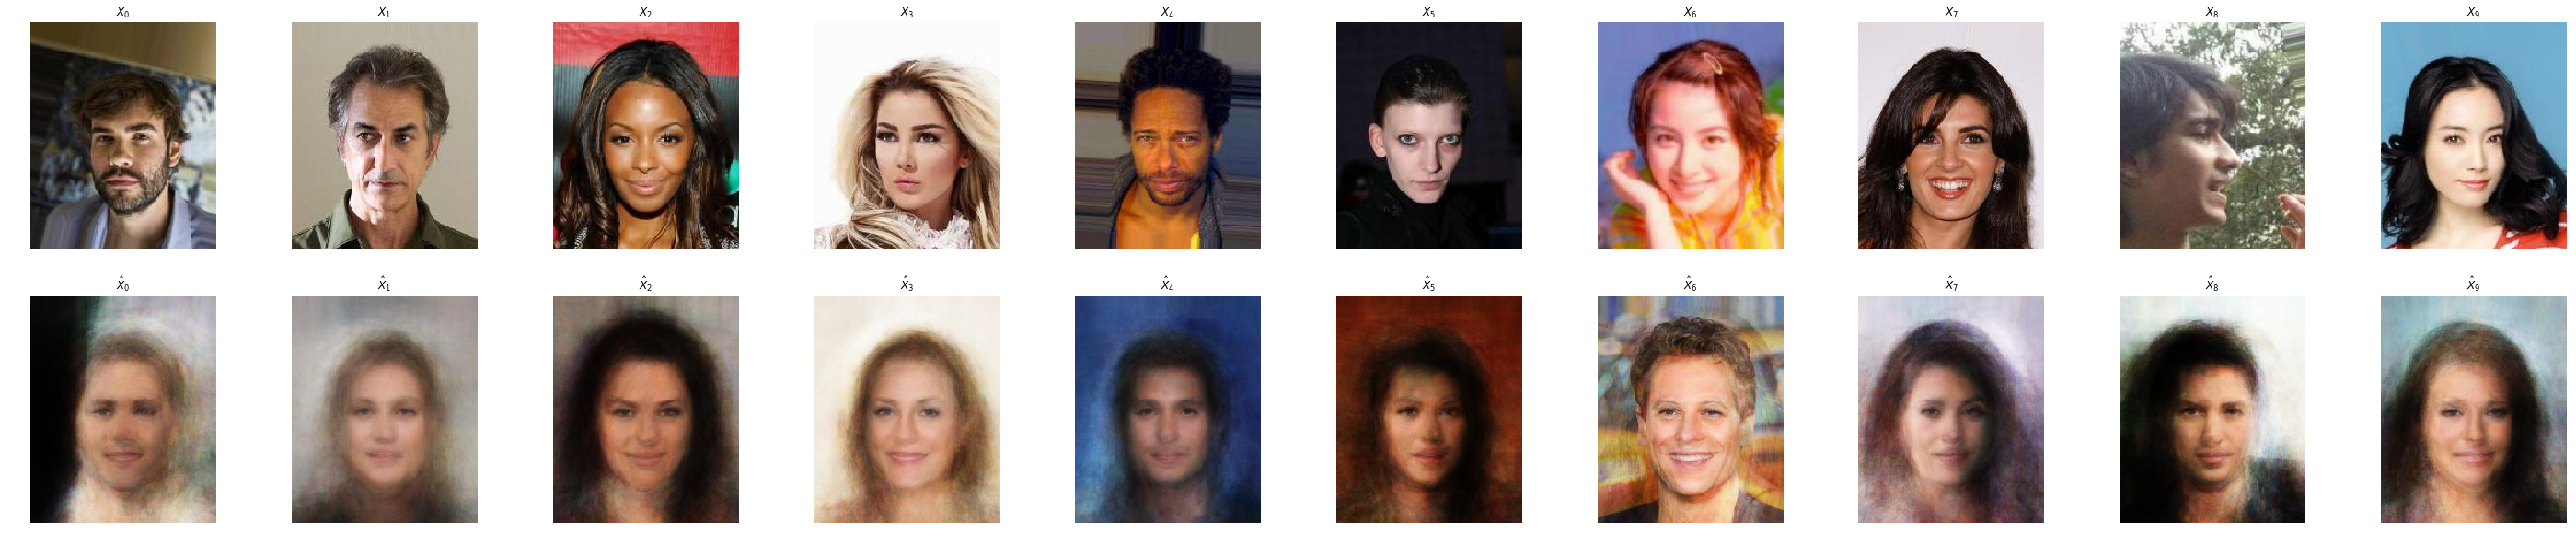

In [18]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (50,10), nrows=2, ncols=10)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            imshow(X_test[j], subplt)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$" %(j))
            imshow(xhat[j], subplt)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

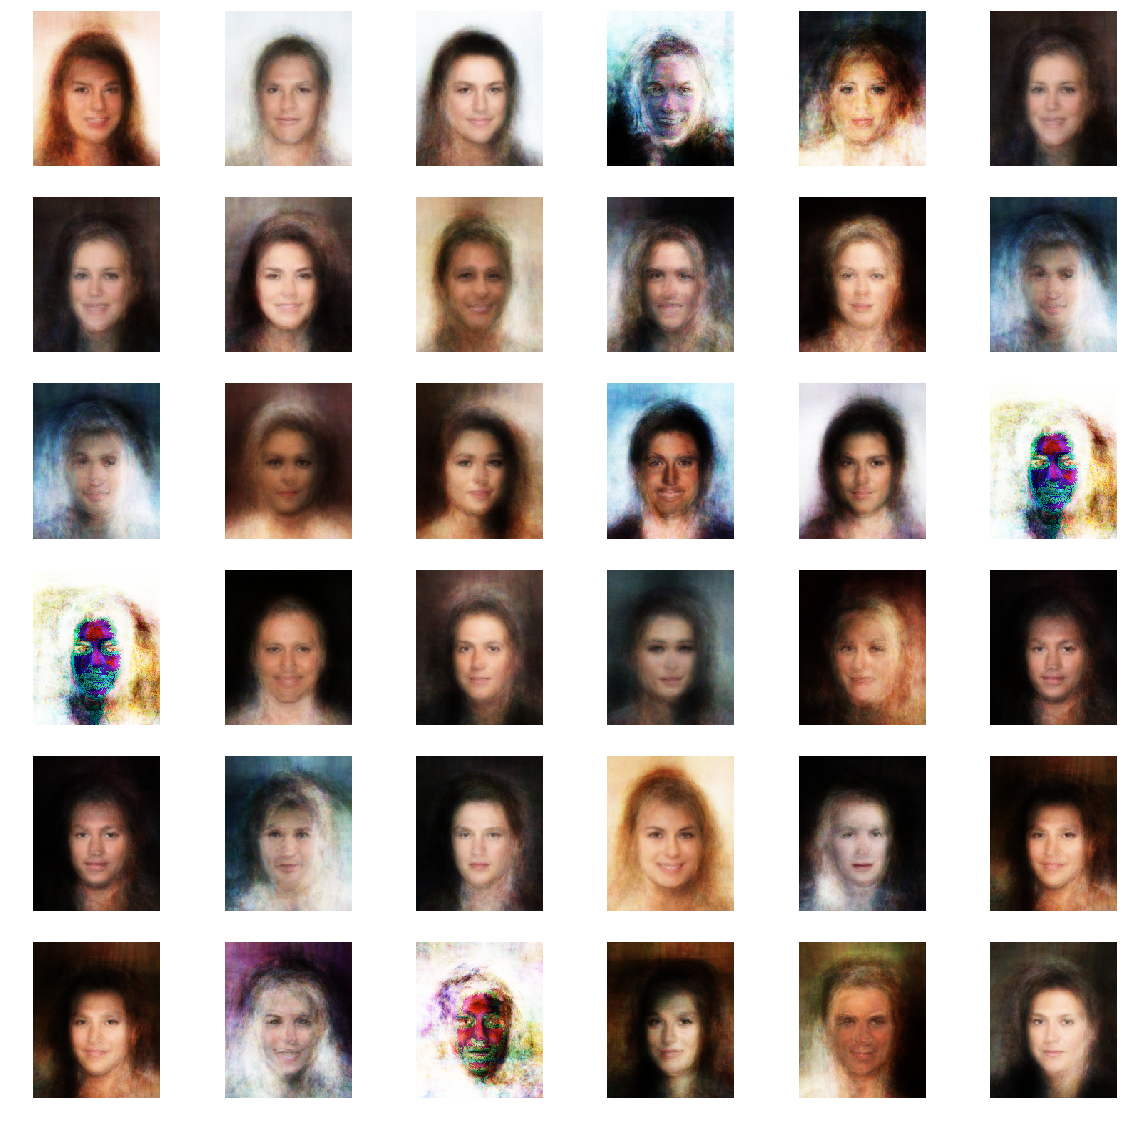

In [19]:
Xgen = oe.sample(36)

xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,20), nrows=6, ncols=6)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(ax)):
        subplt = row[j]
        imshow(Xgen[i*5 +j], subplt)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

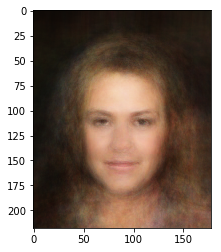

In [20]:
z_cts = np.random.normal(size=(1, n_cts))
if n_categorical > 0:
    onehot = OneHotEncoder(n_values=n_categorical, sparse=False)
    z_categorical = onehot.fit_transform(np.random.randint(n_categorical, size=(1,1)))
    z = np.hstack((z_cts, z_categorical))
else: z = z_cts
Xgen = oe.decode(z)
imshow(Xgen[0])

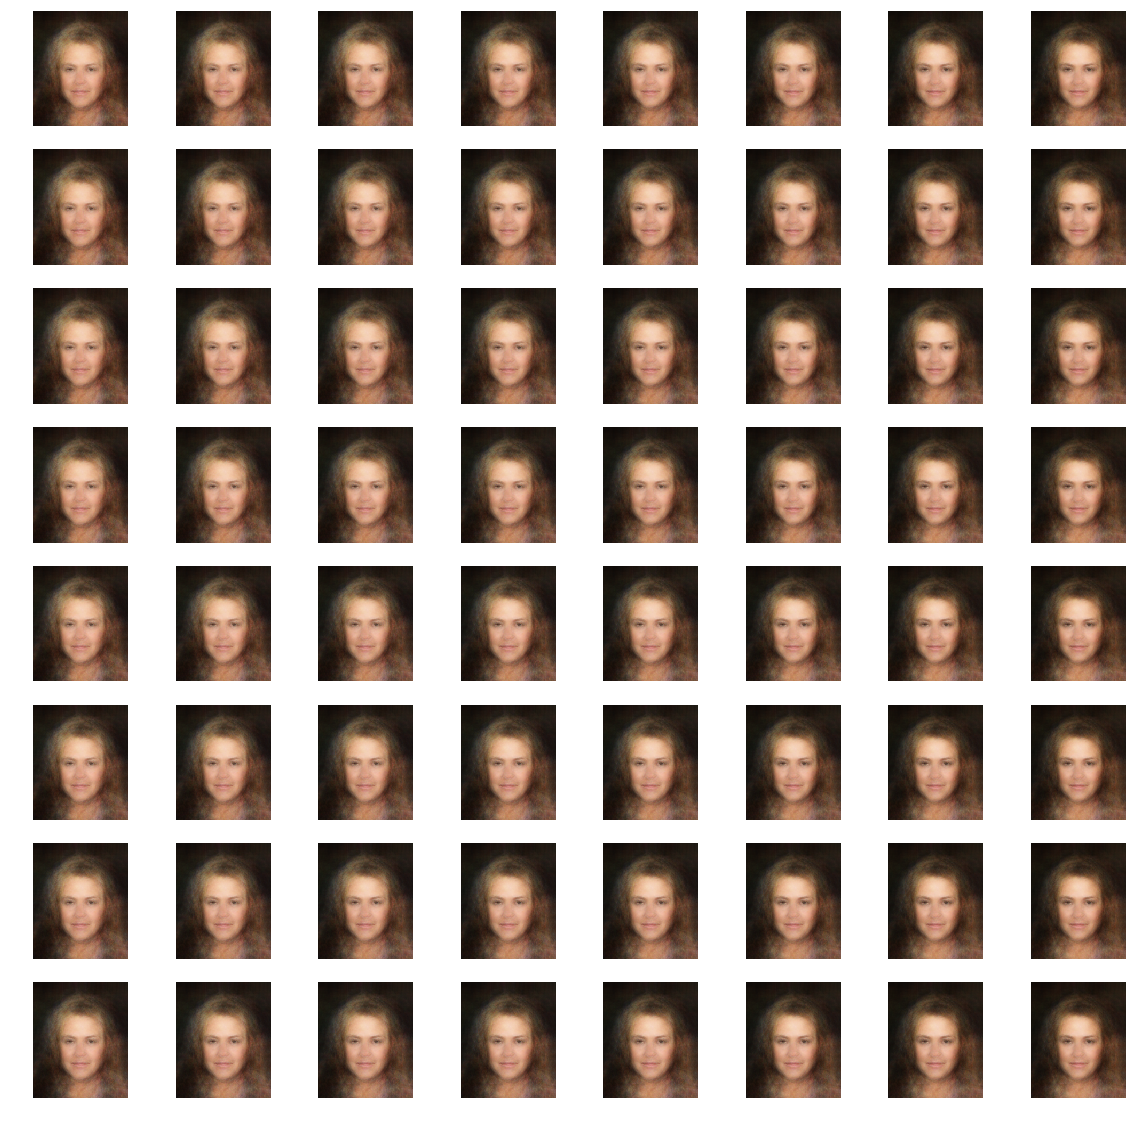

In [21]:
vals = np.arange(-2,2,.5)
n = len(vals)

fig, ax = plt.subplots(figsize = (20,20), nrows=n, ncols=n)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        z_aug = np.copy(z)
        z_aug[:,0] = vals[i]
        z_aug[:,1] = vals[j]
        Xgen = oe.decode(z_aug)
        imshow(Xgen[0], subplt)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()